In [2]:
import numpy as np
import matplotlib.pyplot as plt
from projectq.ops import Rx, Ry, Rz, CNOT, Measure
from projectq.cengines import MainEngine
from projectq.backends import CircuitDrawer, Simulator

# Dataset, binary data and continuous data

In [3]:
def digit_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return x

def binary_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return unpacknbits(x[:,None], num_bit).reshape((-1,)+geometry)

def unpacknbits(arr, nbit, axis=-1):
    '''unpack numbers to bits.'''
    nd = np.ndim(arr)
    if axis < 0:
        axis = nd + axis
    return (((arr & (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1)))) > 0).astype('int8')


def packnbits(arr, axis=-1):
    '''pack bits to numbers.'''
    nd = np.ndim(arr)
    nbit = np.shape(arr)[axis]
    if axis < 0:
        axis = nd + axis
    return (arr * (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1))\
           ).sum(axis=axis, keepdims=True).astype('int')

In [4]:
def gaussian_pdf(geometry, mu, sigma):
    '''get gaussian distribution function'''
    x = digit_basis(geometry)
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()

In [5]:
def barstripe_pdf(geometry):
    '''get bar and stripes PDF'''
    x = binary_basis(geometry)
    pl = is_bs(x)
    return pl/pl.sum()

def is_bs(samples):
    '''a sample is a bar or a stripe.'''
    return (np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2))==0\
           )|((np.abs(np.diff(samples, axis=1)).sum(axis=(1,2)))==0)

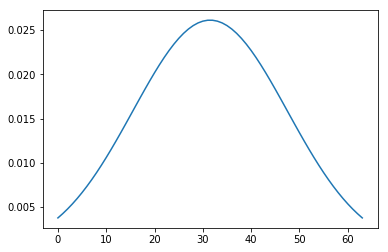

In [12]:
geometry = (6,)
pl1 = gaussian_pdf(geometry, mu=2**5-0.5, sigma=2**4)
plt.plot(pl1)
plt.show()

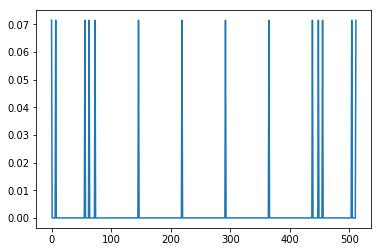

In [14]:
geometry = (3,3)
pl2 = barstripe_pdf(geometry)
plt.plot(pl2)
plt.show()

# Build Circuits

In [23]:
class ArbituaryRotation(object):
    def __init__(self, num_bit):
        self.num_bit = num_bit
        self.mask = np.array([True] * (3*num_bit), dtype='bool')

    def __call__(self, qureg, theta_list):
        nvar = sum(self.mask)
        gates = [Rz, Rx, Rz]
        for i, (theta, mask) in enumerate(zip(theta_list[:nvar], self.mask)):
            ibit, igate = i//3, i%3
            if mask:
                gate = gates[igate](theta)
                gate | qureg[ibit]
        return theta_list[nvar:]

    def __str__(self):
        return 'Rotate[%d]'%(self.num_param)

    @property
    def num_param(self):
        return sum(self.mask)
    
class Entangler(object):
    def __init__(self, num_bit, pairs, gate, num_param_per_pair):
        self.num_bit = num_bit
        self.pairs = pairs
        self.gate = gate
        self.num_param_per_pair = num_param_per_pair
        self.mask = np.array([True]*(num_bit*num_param_per_pair), dtype='bool')

    def __str__(self):
        pair_str = ','.join(['%d-%d'%(i,j) for i,j in self.pairs])
        return '%s(%s)'%(self.gate, pair_str)

    def __call__(self, qureg, theta_list):
        for pair in self.pairs:
            if self.num_param_per_pair == 0:
                gate = self.gate
            else:
                theta_i, theta_list = np.split(theta_list, self.num_param_per_pair)
                gate = self.gate(*theta_i)
            gate | (qureg[pair[0]], qureg[pair[1]])
        return theta_list

    @property
    def num_param(self):
        return sum(self.mask)
    

class BlockQueue(list):
    @property
    def num_bit(self):
        return self[0].num_bit

    @property
    def num_param(self):
        return sum([b.num_param for b in self])

    def __call__(self, qureg, theta_list):
        for block in self:
            theta_list = block(qureg, theta_list)
        np.testing.assert_(len(theta_list)==0)

    def __str__(self):
        return '\n'.join([str(b) for b in self])
    
def cnot_entangler(num_bit, pairs):
    '''controled-not entangler.'''
    return Entangler(num_bit, pairs, CNOT, 0)

def get_demo_circuit(num_bit, depth, pairs):
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbituaryRotation(num_bit))
        if idepth!=depth:
            blocks.append(cnot_entangler(num_bit, pairs))

    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

In [24]:
TEX_FOLDER = 'data'
TEX_FILENAME = '_temp.tex'

class CircuitContext(object):
    '''
    Context for running circuits.

    Args:
        task ('ibm'|'draw'|'simulate'): task that decide the environment type.
        num_bit (int): number of bits in register.
        ibm_config (dict): extra arguments for IBM backend.
    '''

    def __init__(self, task, num_bit, ibm_config=None):
        self.task = task
        self.num_bit = num_bit
        self.ibm_config = ibm_config

    def __enter__(self):
        '''
        Enter context,

        Attributes:
            eng (MainEngine): main engine.
            backend ('graphical' or 'simulate'): backend used.
            qureg (Qureg): quantum register.
        '''
        if self.task=='ibm':
            import projectq.setups.ibm
        else:
            import projectq.setups.default

        # create a main compiler engine with a specific backend:
        if self.task == 'draw':
            self.backend = CircuitDrawer()
            # locations = {0: 0, 1: 1, 2: 2, 3:3} # swap order of lines 0-1-2.
            # self.backend.set_qubit_locations(locations)
        elif self.task == 'simulate':
            self.backend = Simulator()
        elif self.task == 'ibm':
            # choose device
            device = self.ibm_config.get('device', 'ibmqx2' if self.num_bit<=5 else 'ibmqx5')
            # check data
            if self.ibm_config is None:
                raise
            if device == 'ibmqx5':
                device_num_bit = 16
            else:
                device_num_bit = 5
            if device_num_bit < self.num_bit:
                raise AttributeError('device %s has not enough qubits for %d bit simulation!'%(device, self.num_bit))

            self.backend = IBMBackend(use_hardware=True, num_runs=self.ibm_config['num_runs'],
                    user=self.ibm_config['user'],
                    password=self.ibm_config['password'],
                    device=device, verbose=True)
        else:
            raise ValueError('engine %s not defined' % self.task)
        self.eng = MainEngine(self.backend)
        # initialize register
        self.qureg = self.eng.allocate_qureg(self.num_bit)
        return self

    def __exit__(self, *args):
        '''
        exit, meanwhile cheat and get wave function.

        Attributes:
            wf (1darray): for 'simulate' task, the wave function vector.
            res (1darray): for 'ibm' task, the measurements output.
        '''
        if self.task == 'draw':
            self._viz_circuit()
        elif self.task == 'simulate':
            self.eng.flush()
            order, qvec = self.backend.cheat()
            self.wf = np.array(qvec)
            Measure | self.qureg
            self.eng.flush()
        elif self.task == 'ibm':
            Measure | self.qureg
            self.eng.flush()
            self.res = self.backend.get_probabilities(self.qureg)
        else:
            raise
        return self

    def _viz_circuit(self):
        Measure | self.qureg
        self.eng.flush()
        # print latex code to draw the circuit:
        s = self.backend.get_latex()

        # save graph to latex file
        os.chdir(TEX_FOLDER)
        with open(TEX_FILENAME, 'w') as f:
            f.write(s)

        # texfile = os.path.join(folder, 'circuit-%d.tex'%bench_id)
        pdffile = TEX_FILENAME[:-3]+'pdf'
        os.system('pdflatex %s'%TEX_FILENAME)
        openfile(pdffile)

In [25]:
def get_nn_pairs(geometry):
    '''define pairs that cnot gates will apply.'''
    num_bit = np.prod(geometry)
    if len(geometry) == 2:
        nrow, ncol = geometry
        res = []
        for ij in range(num_bit):
            i, j = ij // ncol, ij % ncol
            res.extend([(ij, i_ * ncol + j_)
                        for i_, j_ in [((i + 1) % nrow, j), (i, (j + 1) % ncol)]])
        return res
    elif len(geometry) == 1:
        res = []
        for inth in range(2):
            for i in range(inth, num_bit, 2):
                res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
        return res
    else:
       raise NotImplementedError('')

In [30]:
depth = 2
geometry = (6,)

num_bit = np.prod(geometry)
pairs = get_nn_pairs(geometry)
circuit = get_demo_circuit(num_bit, depth, pairs)
print(circuit)

Rotate[12]
CX(0-1,2-3,4-5,1-2,3-4,5-0)
Rotate[18]
CX(0-1,2-3,4-5,1-2,3-4,5-0)
Rotate[12]


In [37]:
theta_list = np.zeros(circuit.num_param)
theta_list[1] = np.pi
with CircuitContext('simulate', np.prod(geometry)) as cc:
    circuit(cc.qureg, theta_list)

print(cc.wf)

[6.123234e-17+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00-1.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j
 0.000000e+00+0.j 0.000000e+00+0.j

# Build The Gradient training framework for Born Machine

In [46]:
class BornMachine(object):
    '''
    Born Machine,

    Args:
        circuit (BlockQueue): the circuit architechture.
        batch_size (int|None): introducing sampling error, None for no sampling error.
    '''
    def __init__(self, circuit, mmd, p_data, batch_size=None):
        self.circuit = circuit
        self.mmd = mmd
        self.p_data = p_data
        self.batch_size = batch_size

    @property
    def depth(self):
        return (len(self.circuit)-1)//2

    def viz(self, theta_list=None):
        '''visualize this Born Machine'''
        if theta_list is None:
            theta_list = np.random.random(circuit.num_param)*2*np.pi
        with CircuitContext('draw', self.circuit.num_bit) as cc:
            self.circuit(cc.qureg, theta_list)

    def pdf(self, theta_list):
        '''get probability distribution function'''
        with CircuitContext('simulate', self.circuit.num_bit) as cc:
            self.circuit(cc.qureg, theta_list)
        pl = np.abs(cc.wf)**2
        # introducing sampling error
        if self.batch_size is not None:
            pl = prob_from_sample(sample_from_prob(np.arange(len(pl)), pl, self.batch_size),
                    len(pl), False)
        return pl

    def mmd_loss(self, theta_list):
        '''get the loss'''
        # get probability distritbution of Born Machine
        self._prob = self.pdf(theta_list)
        # use wave function to get mmd loss
        return self.mmd(self._prob, self.p_data)

    def gradient(self, theta_list):
        '''
        cheat and get gradient.
        '''
        prob = self._prob
        grad = []
        for i in range(len(theta_list)):
            # pi/2 phase
            theta_list[i] += np.pi/2.
            prob_pos = self.pdf(theta_list)
            # -pi/2 phase
            theta_list[i] -= np.pi
            prob_neg = self.pdf(theta_list)
            # recover
            theta_list[i] += np.pi/2.

            grad_pos = self.mmd.kernel_expect(prob, prob_pos) - self.mmd.kernel_expect(prob, prob_neg)
            grad_neg = self.mmd.kernel_expect(self.p_data, prob_pos) - self.mmd.kernel_expect(self.p_data, prob_neg)
            grad.append(grad_pos - grad_neg)
        return np.array(grad)

    def gradient_numerical(self, theta_list, delta=1e-2):
        '''
        numerical differenciation.
        '''
        grad = []
        for i in range(len(theta_list)):
            theta_list[i] += delta/2.
            loss_pos = self.mmd_loss(theta_list)
            theta_list[i] -= delta
            loss_neg = self.mmd_loss(theta_list)
            theta_list[i] += delta/2.

            grad_i = (loss_pos - loss_neg)/delta
            grad.append(grad_i)
        return np.array(grad)
    
def sample_from_prob(x, pl, num_sample):
    '''
    sample x from probability.
    '''
    pl = 1. / pl.sum() * pl
    indices = np.arange(len(x))
    res = np.random.choice(indices, num_sample, p=pl)
    return np.array([x[r] for r in res])


def prob_from_sample(dataset, hndim, packbits):
    '''
    emperical probability from data.
    '''
    if packbits:
        dataset = packnbits(dataset).ravel()
    p_data = np.bincount(dataset, minlength=hndim)
    p_data = p_data / float(np.sum(p_data))
    return p_data

# MMD Loss Function

In [43]:
class RBFMMD2(object):
    def __init__(self, sigma_list, basis):
        self.sigma_list = sigma_list
        self.basis = basis
        self.K = mix_rbf_kernel(basis, basis, self.sigma_list)

    def __call__(self, px, py):
        '''
        Args:
            px (1darray, default=None): probability for data set x, used only when self.is_exact==True.
            py (1darray, default=None): same as px, but for data set y.

        Returns:
            float, loss.
        '''
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        return px.dot(self.K).dot(py)

def mix_rbf_kernel(x, y, sigma_list):
    ndim = x.ndim
    if ndim == 1:
        exponent = np.abs(x[:, None] - y[None, :])**2
    elif ndim == 2:
        exponent = ((x[:, None, :] - y[None, :, :])**2).sum(axis=2)
    else:
        raise
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

In [41]:
def load_gaussian(num_bit, depth):
    '''gaussian distribution.'''
    geometry = (num_bit,)
    hndim = 2**num_bit

    # standard circuit
    pairs = get_nn_pairs(geometry)
    circuit = get_demo_circuit(num_bit, depth, pairs)

    # bar and stripe
    p_bs = gaussian_pdf(geometry, mu=hndim/2., sigma=hndim/4.)

    # mmd loss
    mmd = RBFMMD2(sigma_list=[0.25,0.5,1,2,4], basis=digit_basis(geometry))

    # Born Machine
    bm = BornMachine(circuit, mmd, p_bs)
    return bm

In [47]:
depth = 2
np.random.seed(2)

bm = load_gaussian(6, depth)
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi

print(bm.mmd_loss(theta_list))

0.2824720329076462
[ 0.00000000e+00 -2.59178300e-02 -7.24270356e-05  0.00000000e+00
  5.16554030e-02  1.67222262e-02  0.00000000e+00 -1.75269941e-01
  9.19424882e-02  0.00000000e+00 -2.36448075e-01  3.55242335e-02
 -7.24270356e-05 -4.50239861e-02 -2.66219836e-03  1.26011279e-02
  2.41074436e-01 -5.44497917e-04 -7.94454030e-02 -4.90431541e-02
 -1.87151009e-02 -4.12811183e-02  1.89254835e-01  8.67344454e-04
 -4.12811183e-02 -1.89231371e-01 -2.39523619e-02  0.00000000e+00
 -1.10398945e-01  2.46328213e-02  2.04279584e-03 -6.51239647e-02
  0.00000000e+00 -6.58965192e-04 -1.14377062e-01  0.00000000e+00
 -2.49440513e-02 -1.15818007e-01  0.00000000e+00 -1.85395121e-02
  1.59777814e-01  0.00000000e+00]
[ 0.00000000e+00 -2.59178300e-02 -7.24270356e-05  0.00000000e+00
  5.16554030e-02  1.67222262e-02  0.00000000e+00 -1.75269941e-01
  9.19424882e-02  0.00000000e+00 -2.36448075e-01  3.55242335e-02
 -7.24270356e-05 -4.50239861e-02 -2.66219836e-03  1.26011279e-02
  2.41074436e-01 -5.44497917e-04 -7.9

In [50]:
g1 = bm.gradient(theta_list)
print(g1)
g2 = bm.gradient_numerical(theta_list)
print(g2)

[ 0.00000000e+00 -2.59178300e-02 -7.24270356e-05  0.00000000e+00
  5.16554030e-02  1.67222262e-02  0.00000000e+00 -1.75269941e-01
  9.19424882e-02  0.00000000e+00 -2.36448075e-01  3.55242335e-02
 -7.24270356e-05 -4.50239861e-02 -2.66219836e-03  1.26011279e-02
  2.41074436e-01 -5.44497917e-04 -7.94454030e-02 -4.90431541e-02
 -1.87151009e-02 -4.12811183e-02  1.89254835e-01  8.67344454e-04
 -4.12811183e-02 -1.89231371e-01 -2.39523619e-02  5.55111512e-17
 -1.10398945e-01  2.46328213e-02  2.04279584e-03 -6.51239647e-02
  0.00000000e+00 -6.58965192e-04 -1.14377062e-01  0.00000000e+00
 -2.49440513e-02 -1.15818007e-01  0.00000000e+00 -1.85395121e-02
  1.59777814e-01  0.00000000e+00]
[ 0.00000000e+00 -2.59171542e-02 -7.24291418e-05  0.00000000e+00
  5.16540455e-02  1.67221009e-02  0.00000000e+00 -1.75265659e-01
  9.19420062e-02  0.00000000e+00 -2.36443591e-01  3.55242038e-02
 -7.24291418e-05 -4.50235490e-02 -2.66218723e-03  1.26010222e-02
  2.41070757e-01 -5.44497732e-04 -7.94450016e-02 -4.9041

# Different Training Strategies

In [51]:
def train(bm, theta_list, method, max_iter=1000, popsize=50, step_rate=0.1):
    '''train a Born Machine.'''
    theta_list = np.array(theta_list)
    if method == 'DE':
        from scipy.optimize import differential_evolution
        res = differential_evolution(bm.mmd_loss,
                                     maxiter=max_iter, popsize=popsize,
                                     options={'disp': 2, 'iprint': 2})
    elif method == 'Adam':
        from climin import Adam
        optimizer = Adam(wrt=theta_list, fprime=bm.gradient,step_rate=step_rate)
        for info in optimizer:
            step = info['n_iter']
            loss = bm.mmd_loss(theta_list)
            print('step = %d, loss = %s'%(step, loss))
            if step == max_iter:
                break
        return bm.mmd_loss(theta_list), theta_list
    else:
        from scipy.optimize import minimize
        res = minimize(bm.mmd_loss, x0=theta_list,
                       method=method, jac = bm.gradient, tol=1e-12,
                       options={'maxiter': max_iter, 'disp': 2, 'gtol':1e-10, 'ftol':0},
                       )
        return res.fun, res.x

In [53]:
depth = 6
np.random.seed(2)

bm = load_gaussian(6, depth)
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'L-BFGS-B', max_iter=20)
pl = bm.pdf(theta_list)

# display
plt.ion()
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine'])
pdb.set_trace()

KeyboardInterrupt: 

In [ ]:
def load_barstripe(geometry, depth):
    '''3 x 3 bar and stripes.'''
    num_bit = np.prod(geometry)

    # standard circuit
    pairs = get_nn_pairs(geometry)
    circuit = get_demo_circuit(num_bit, depth, pairs)

    # bar and stripe
    p_bs = barstripe_pdf(geometry)

    # mmd loss
    mmd = RBFMMD2(sigma_list=[0.5,1,2,4], basis=binary_basis((num_bit,)))

    # Born Machine
    bm = BornMachine(circuit, mmd, p_bs)
    return bm

In [ ]:
np.random.seed(2)
depth = 4

bm = load_barstripe((2, 2), depth)
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'L-BFGS-B', max_iter=20)
pl = bm.pdf(theta_list)

# display
plt.ion()
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Gradient Born Machine'])
pdb.set_trace()